In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import pulp
import math
import random
import numpy as np

In [2]:
#points and distance
resolution = 10000  # city of about 10km diameter

In [3]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [4]:
def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        d=dist(X, p)
        if d<minD:
            minP, minD = p, d
    return minP    

In [5]:
def generatePoints(n):
    
    def gen():
        x = int(random.gauss(mu=resolution/2, sigma=resolution/8))
        return min(resolution-50, max(50, x))
    
    mindist = resolution/(2*math.sqrt(n)) 
    # avoid points to neart to each other
    P = []
    while len(P)<n:
        i=len(P)
    
        x0=gen()
        y0=gen()
        
        # don't place new points near existing points
        P.append((x0,y0))
        for j in range(0,i):
            if dist(P[i],P[j])<mindist:
                P=P[:-1]
                break
    return P

In [6]:
#Lines
def equalLines(l1, l2):
    if l1==l2:
        return True
    else:
        return l1[0]==l2[1] and l1[1]==l2[0]

In [7]:
def rev(L):
    return L[1],L[0]

In [8]:
def solve(x11, x12, y1, x21, x22, y2):
    
    def Det(x11, x12, x21, x22):
        return x11*x22-x21*x12

    D = Det(x11, x12, x21, x22)
    Ds = Det(y1, x12, y2, x22)
    Dt = Det(x11, y1, x21, y2)
    if D==0:
        return False
    s=Ds/D
    t=Dt/D
    return 0 <= s and s <= 1 and 0 <= t and t <= 1
    
def intersecting(l1, l2):
    p1, p2 = l1
    q1, q2 = l2
    if p1==q1 or p1==q2 or p2==q1 or p2==q2:
        return False
    xp1, yp1 = p1
    xp2, yp2 = p2
    xq1, yq1 = q1
    xq2, yq2 = q2
    return solve(xp2-xp1, xq1-xq2, xq1-xp1,
                 yp2-yp1, yq1-yq2, yq1-yp1)



In [9]:
#Traiangle
def equalTriangles(t1, t2):
    P1, P2, P3 = t1
    Q1, Q2, Q3 = t2
    if P1==Q1:
        if P2==Q2:
            return P3==Q3
        elif P2==Q3:
            return P3==Q2
        else:
            return False
    elif P1==Q2:
        if P2==Q1:
            return P3==Q3
        elif P2==Q3:
            return P3==Q1
        else:
            return False
    elif P1==Q3:
        if P2==Q1:
            return P3==Q2
        elif P2==Q2:
            return P3==Q1
        else:
            return False
    else:
        return False

In [10]:
def removeTriangle(t, T):
    for tt in T:
        if equalTriangles(t, tt):
            T.remove(tt)
            return True
    return False  

In [11]:
def addTriangle(t, T):
    for tt in T:
        if equalTriangles(t, tt):
            return
    T.append(t) 

In [12]:
def area(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return abs(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))/2

In [13]:
def insideTriangle(x, t):
    p, q, r = t
    if x==p or x==q or x==r:
        return False
    return abs(area(p,q,x) + area(p,r,x)+ area(q,r,x) - area(p,q,r))<0.00001

In [14]:
def sides(t):
    A, B, C = t
    return [(B, C), (C, A), (A, B)]

In [15]:
def longestSide(t):
    return sorted(sides(t), key=lambda s: dist(s[0], s[1]), reverse=True)[0]

In [16]:
def commonSide(t1, t2):
    S1 = sides(t1)
    S2 = sides(t2)
    for s1 in S1:
        for s2 in S2:
            if equalLines(s1, s2):
                return s1
    return None

In [17]:
def oppositePoint(t, l):
    A, B, C = t
    P, Q = l
    if A==P:
        return C if B==Q else B
    elif A==Q:
        return C if B==P else B
    else:
        return A

In [18]:
def intersectingTriangles(c1, c2):
    c= commonSide(c1, c2)
    if c is None:
        return False
    A, B = c
    C1 = oppositePoint(c1, c)
    C2 = oppositePoint(c2, c)
    return intersecting((A, C1), (B,C2)) or \
            intersecting((A, C2), (B, C1))

def intersectingLines(c1, c2):
    c= commonSide(c1, c2)
    if c is None:
        return None
    A, B = c
    C1 = oppositePoint(c1, c)
    C2 = oppositePoint(c2, c)
    if intersecting((A, C1), (B,C2)):
        return (A, C1), (B,C2)
    elif intersecting((A, C2), (B, C1)):
        return (A, C2), (B, C1)
    else:
        return None

In [19]:
def defuse(t1, t2):
    # is only called if intersectingTriangles(t1, t2)
    l1, l2 = intersectingLines(t1, t2)
    c = commonSide(t1, t2)
    if c is None:
        return None
    A, B = c
    C1 = oppositePoint(t1, c)
    C2 = oppositePoint(t2, c)
    if intersecting((A, C1), (B,C2)):
        return [C1, C2, A]
    elif intersecting((A, C2), (B, C1)):
        return [C1, C2, B]

In [20]:
def slimTriangle(t):
    A, B, C = t
    a = dist(B,C)
    b = dist(A,C)
    c = dist(A,B)
    [a, b, c] = sorted([a, b, c])
    return a+b<1.07*c

In [21]:
def plotTriangle(t, style='r-o', lw=1, ms=3):
    p1, p2, p3 = t
    plt.plot( [ p1[0], p2[0], p3[0], p1[0] ],
              [ p1[1], p2[1], p3[1], p1[1] ], 
              style, lw=lw, ms=ms)

def plotTriangles(T, style='r-o', lw=1, ms=3):
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    plt.axis('off')
    for t in T:
        plotTriangle(t, style, lw=lw, ms=ms)
    plt.show()

In [22]:
#Traingulation
def triangulation(P, show=False):
    x = [ p[0] for p in P ]
    y = [ p[1] for p in P ]
    minx = min(x)
    maxx = max(x)
    miny = min(y)
    maxy = max(y)
    nmaxx = 1.1 * maxx
    nmaxy = 1.1 * maxy
    nminx = max(0.5 * minx, 0)
    nminy = max(0.5 * miny, 0)
    distx = nmaxx-nminx
    disty = nmaxy-nminy
    d = math.sqrt(distx*disty/(2*len(P)))
    dx = math.ceil(distx/d)
    dy = math.ceil(disty/d)

        
    def kx(i):
        return nminx+i*d
    
    def ky(j):
        return nminy+j*d
    
    def k(i, j):
        return (kx(i), ky(j))
    
    # def n(i, j):
    #     return nearest( (kx(i), ky(j)), P)
    def n(i, j):
        X = (kx(i), ky(j))
        minD = math.inf
        minP = None
        for p in P:
            d=dist(X, p)
            if d<minD:
                minP, minD = p, d
        return minP  

    if show:

        plt.figure(0)
        plt.xlim(0,resolution)
        plt.ylim(0,resolution)
        plt.axis('off')
    
        plt.plot([ p[0] for p in P ], 
                 [ p[1] for p in P ], 'ro', ms=10)    
    
        for i in range(0, dx+1):
            for j in range(0, dy):
                plt.plot( [ kx(i), kx(i) ],
                          [ ky(j), ky(j+1) ], 'b:.')
            
        for j in range(0, dy+1):
            for i in range(0, dx):
                plt.plot( [ kx(i), kx(i+1) ],
                          [ ky(j), ky(j) ], 'b:.')
            
        for i in range(0, dx):
            for j in range(0, dy):
                plt.plot( [ kx(i), kx(i+1) ],
                          [ ky(j), ky(j+1) ], 'b:.')
    
        for i in range(0, dx+1):
            for j in range(0, dy+1):
                nx, ny = n(i,j)
                plt.plot( [ kx(i), nx ],
                          [ ky(j), ny ], 'g:')


    
    # set of triangles
    T = []
    for i in range(0, dx):
        for j in range(0, dy):
            p1=n(i,j)
            p2=n(i+1, j)
            p3=n(i, j+1)
            p4=n(i+1, j+1)
            if p1!=p2 and p2!=p4 and p4!=p1:
                addTriangle([p1, p2, p4], T)
            if p1!=p3 and p3!=p4 and p4!=p1:
                addTriangle([p1, p3, p4], T)
                  
    # Replace a triangle containing an inner point
    # with three triangles formed from this inner point
    C = T.copy()
    for p in P:
        for t in T:
            if insideTriangle(p, t):
                p1, p2, p3 = t
                C.remove(t)
                C.append( (p1, p2, p) )
                C.append( (p2, p3, p) )
                C.append( (p3, p1, p) )
         
    PLOT = 0
    
    def showTriangulation(T, style='r-o', check=False):
        nonlocal PLOT
        PLOT += 1
        plt.figure(PLOT)
        plt.xlim(0,resolution)
        plt.ylim(0,resolution)
        plt.axis('off')
        for t in T:
            plotTriangle(t, 'r-o', lw=0.5)
        
        if check:
            found=False
            for t1 in T:
                for t2 in T:
                    if t1!=t2 and intersectingTriangles(t1, t2):
                        plotTriangle(t1, 'b-o')
                        plotTriangle(t2, 'g-o')
                        found=True
                        break
                if found:
                    break
  
    found = True
    while found:
        
        if show:
            showTriangulation(C)
        
        D=C.copy()
        found = False
        for c1 in C:
            for c2 in C:
                if c1!=c2 and intersectingTriangles(c1, c2):
                    # print(f"replacing")
                    # print(triangle_String(c1))
                    # print(triangle_String(c2))
                    c3=defuse(c1, c2)
                    removeTriangle(c2, D)
                    # print(triangle_String(c3))
                    addTriangle(c3, D)
                    found=True
                    break
            if found:
                break
        C=D
        
    # Check for isolated points
    # This can now probably not happen anymore, 
    # but just leave it in for now
    
    def isolated(p, C):
        for c in C:
            p1, p2, p3 = c
            if p==p1 or p==p2 or p==p3:
                return False
        return True
    
    for p in P:
        if isolated(p, D):
            plt.plot( [ p[0] ], [ p[1] ], 'ko', ms=15)
                    
    return C

In [23]:
#Graphs
def element(p, S):
    for s in S:
        if s==p: # s[0]==p[0] and s[1]==p[1]:
            return True
    return False
        
def vertices(T):
    S = []
    for t in T:
        A, B, C = t
        if not element(A, S):
            S.append(A)
        if not element(B, S):
            S.append(B)
        if not element(C, S):
            S.append(C)
    return sorted(S, key=lambda p: p[0])

def edges(T):
    S = []
    for t in T:
        A, B, C = sides(t)
        if not element(A, S) and not element(rev(A), S):
            S.append(A)
        if not element(B, S) and not element(rev(B), S):
            S.append(B)
        if not element(C, S) and not element(rev(C), S):
            S.append(C)
    return sorted(S, key=lambda p: p[0][0])

def graph(T):
    return vertices(T), edges(T)

In [24]:
#Lists and Paths
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [25]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [26]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [27]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

In [28]:
#Maps
def createMap(P, p=0.2):
    T = triangulation(P)
    V, E = graph(T)
    
    for t in T:
        if slimTriangle(t):
            s = longestSide(t)
            if s in E:
                E.remove(s)
            elif (s[1], s[0]) in E:
                E.remove((s[1], s[0]))
        else:
            for tt in T:
                if not equalTriangles(t, tt):
                    s = commonSide(t, tt)
                    if s is None:
                        continue
                    if random.random()<p:
                        if s in E:
                            E.remove(s)
                            break
                        elif (s[1], s[0]) in E:
                            E.remove((s[1], s[0]))
                            break
                    
    return V, E

In [29]:
def placeWarehouse(M):
    V, _ = M
    dmin = math.inf
    pos = (random.randint(resolution/4, resolution*3/4),
            random.randint(resolution/4, resolution*3/4))
    for p in V:
        dp = dist(p, pos)
        if dp<dmin:
            w = p
            dmin = dp
    return w

In [30]:
def splitEdge(V, E, s):
    A, B = s
    p = random.uniform(0.2,0.8)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [31]:
def addTargets(M, n=5):
    V, E = M
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 0.05
    while len(T)<n:
        S = random.sample(E, 1)
        s = S[0]
        A, B = s
        if dist(A,B)>resolution/20: # avoid targets placed narrowly
            (V, E), t = splitEdge(V, E, s)
            T.append(t)
    return (V, E), T

In [32]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(0.8*resolution, 0, text)
    if grid:
        plt.grid()
    plt.show()

In [33]:
def generateData(seed=None, nodes=50, customers=100, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, W, C = generateData(seed=None, plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("        For the generating proper simulation data, use the last")
        print("        four digits of your student ID as seed value.")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  W ∈ V  is the location of the distribution warehouse")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  C ⊆ V  is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates")
        print("    len(C) gives the number of customers generated")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 10       # number of points in map
        customers = 5    # number of  customers
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    P = generatePoints(nodes)
    
    M = createMap(P)
    W = placeWarehouse(M)
    MT, C = addTargets(M, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap(MT, T=C, w=W, text=label, grid=grid)
    
    return MT, W, C

In [34]:
M, W, C = generateData()

Usage:  M, W, C = generateData(seed=None, plot=False, log=False)

  seed  the seed value to be used for data generation. 
        To test the application use seed=0, it will create
        a small map, with a very few customer locations and
        a small set of delivery data.
        For the generating proper simulation data, use the last
        four digits of your student ID as seed value.

  log   Controls print output during data generation.

  plot  Controls graphical output during data generation.

Returns:

  M = (V, E) is the generated map given as a graph
    where V is a list of vertices, with each vertice 
    given as a pair (x, y) of integer coordinates, 
    and E is a list of edges, with each edge given
    as a pair (A, B) of vertices, with each vertex again
    given as a pair (x, y) of integer coordinates

  W ∈ V  is the location of the distribution warehouse
    given as a pair (x, y) of integer coordinates

  C ⊆ V  is a list of customer locations
    given as pa

Generated map with 10 nodes and 5 customer locations


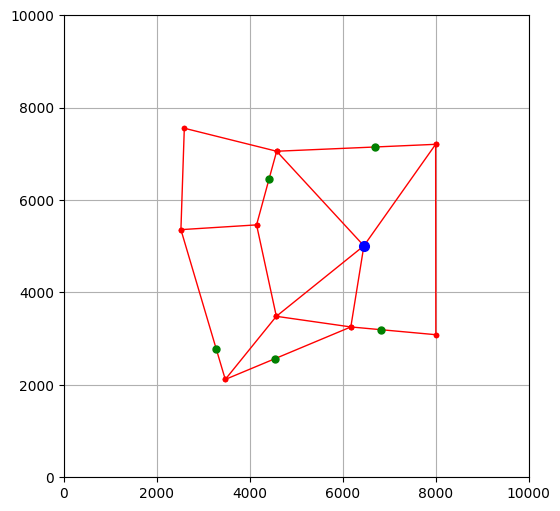

In [35]:
#Generating sample data
M, W, C = generateData(seed=0, log=True, plot=True)

In [36]:
V, E = M
V

[(2523, 5360),
 (2596, 7555),
 (3477, 2118),
 (4150, 5463),
 (4575, 3484),
 (4582, 7057),
 (6177, 3254),
 (6458, 5010),
 (8001, 7207),
 (8005, 3086),
 (4546, 2567),
 (4421, 6466),
 (6818, 3195),
 (3285, 2769),
 (6698, 7149)]

In [37]:
E

[((2523, 5360), (2596, 7555)),
 ((2596, 7555), (4582, 7057)),
 ((4150, 5463), (2523, 5360)),
 ((4575, 3484), (3477, 2118)),
 ((4575, 3484), (4150, 5463)),
 ((4575, 3484), (6177, 3254)),
 ((6177, 3254), (6458, 5010)),
 ((6458, 5010), (4575, 3484)),
 ((6458, 5010), (4582, 7057)),
 ((8001, 7207), (6458, 5010)),
 ((8005, 3086), (8001, 7207)),
 ((6177, 3254), (4546, 2567)),
 ((4546, 2567), (3477, 2118)),
 ((4150, 5463), (4421, 6466)),
 ((4421, 6466), (4582, 7057)),
 ((8005, 3086), (6818, 3195)),
 ((6818, 3195), (6177, 3254)),
 ((3477, 2118), (3285, 2769)),
 ((3285, 2769), (2523, 5360)),
 ((4582, 7057), (6698, 7149)),
 ((6698, 7149), (8001, 7207))]

In [38]:
C

[(4546, 2567), (4421, 6466), (6818, 3195), (3285, 2769), (6698, 7149)]

Generated map with 50 nodes and 100 customer locations


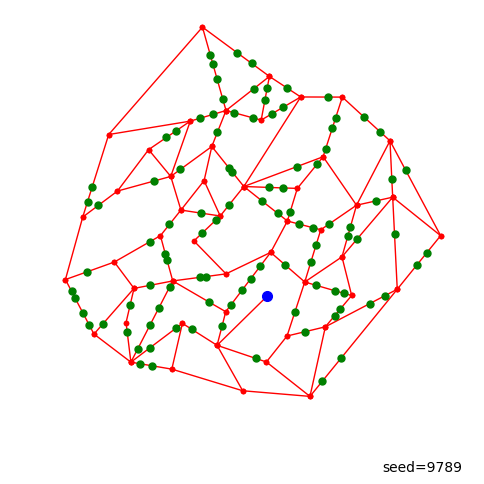

In [39]:
#Real data genaration with seed value of my last 4 digits of student id
data = generateData(9789, plot=True, log=True)

In [40]:
import pickle
with open('data.pickled', 'wb') as f:
    pickle.dump(data, f)

In [41]:
import pickle
with open('data.pickled', 'rb') as f:
     M, W, C = pickle.load(f)

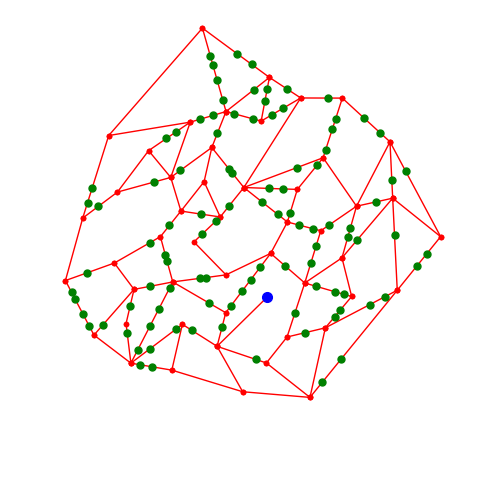

In [42]:
plotMap(M, T=C, w=W)